In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import ruamel.yaml
import math
import numpy as np
import tarfile
from matplotlib import cm
from matplotlib import pyplot as plt
import warnings
import yaml
yaml_format = ruamel.yaml.YAML()
warnings.filterwarnings('ignore')

import matplotlib.ticker as ticker  # Add this import at the top


In [20]:
def get_data_dir(subfolder):
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    print(current_dir)
    return os.path.join(current_dir, "experiment_data", subfolder)


In [21]:
def derived_papi(PAPI_data):
    DERIVED = {}
    DERIVED['TOT_INS_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_INS'].time)
    })
    DERIVED['TOT_CYC_PER_INS'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_CYC'].time)
    })
    DERIVED['L3_TCM_PER_TCA'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_L3_TCM']['instantaneous_value']) / np.array(PAPI_data['PAPI_L3_TCA']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_L3_TCM'].time)
    })  
    DERIVED['TOT_STL_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_RES_STL']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_RES_STL'].time)
    })
    
    # Create a mask for non-NaN values across all keys
    mask = ~DERIVED['TOT_INS_PER_CYC']['value'].isna()  # Start with one key to create the mask
    for key in DERIVED:
        mask &= ~DERIVED[key]['value'].isna()  # Combine masks for all keys

    for key in DERIVED:
        DERIVED[key] = DERIVED[key][mask]  # Filter each DataFrame using the combined mask

    return DERIVED

def calculate_power_with_wraparound(current, previous, time_diff, wraparound_value=262143.328850):
    diff = current - previous
    if diff < 0:  # Wraparound detected
        diff = (wraparound_value - previous) + current
    return diff / time_diff

def compute_power(pubEnergy):
    power = {}
    geopm_sensor0 = geopm_sensor1 = pd.DataFrame({'timestamp':[],'value':[]})
    for i,row in pubEnergy.iterrows():
        if i%2 == 0:
            geopm_sensor0 = pd.concat([geopm_sensor0, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)
        else:
            geopm_sensor1 = pd.concat([geopm_sensor1, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)


    power['geopm_power_0'] = pd.DataFrame({
        'timestamp': geopm_sensor0['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor0['value'][i],
                geopm_sensor0['value'][i-1],
                geopm_sensor0['timestamp'][i] - geopm_sensor0['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor0))
        ]
    })

    # Apply the same logic to geopm_power_1
    power['geopm_power_1'] = pd.DataFrame({
        'timestamp': geopm_sensor1['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor1['value'][i],
                geopm_sensor1['value'][i-1],
                geopm_sensor1['timestamp'][i] - geopm_sensor1['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor1))
        ]
    })

    min_length = min(len(power['geopm_power_0']), len(power['geopm_power_1']))
    geopm_power_0 = power['geopm_power_0'][:min_length]
    geopm_power_1 = power['geopm_power_1'][:min_length]

    average_power = pd.DataFrame({
        'timestamp': geopm_power_0['timestamp'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['power'], geopm_power_1['power'])]
    })
    average_power['elapsed_time'] = average_power['timestamp'] - average_power['timestamp'].iloc[0]
    power['average_power'] = average_power
    return power

def measure_progress(progress_data, energy_data):
    Progress_DATA = {} 
    progress_sensor = pd.DataFrame(progress_data)
    first_sensor_point = min(energy_data['average_power']['timestamp'].iloc[0], progress_sensor['time'][0])
    progress_sensor['elapsed_time'] = progress_sensor['time'] - first_sensor_point  # New column for elapsed time
    # progress_sensor = progress_sensor.set_index('elapsed_time')
    performance_elapsed_time = progress_sensor.elapsed_time
    # Add performance_frequency as a new column in progress_sensor
    frequency_values = [
        progress_data['value'].iloc[t] / (performance_elapsed_time[t] - performance_elapsed_time[t-1]) for t in range(1, len(performance_elapsed_time))
    ]
    
    # Ensure the frequency_values length matches the index length
    frequency_values = [0] + frequency_values  # Prepend a 0 for the first index
    progress_sensor['frequency'] = frequency_values
    upsampled_timestamps= energy_data['average_power']['timestamp']
    
    # true_count = (progress_sensor['time'] <= upsampled_timestamps.iloc[0]).sum()

    progress_frequency_median = pd.DataFrame({'median': np.nanmedian(progress_sensor['frequency'].where(progress_sensor['time'] <= upsampled_timestamps.iloc[0])), 'timestamp': upsampled_timestamps.iloc[0]}, index=[0])
    for t in range(1, len(upsampled_timestamps)):
        progress_frequency_median = pd.concat([progress_frequency_median, pd.DataFrame({'median': [np.nanmedian(progress_sensor['frequency'].where((progress_sensor['time'] >= upsampled_timestamps.iloc[t-1]) & (progress_sensor['time'] <= upsampled_timestamps.iloc[t])))],
        'timestamp': [upsampled_timestamps.iloc[t]]})], ignore_index=True)
    progress_frequency_median['elapsed_time'] = progress_frequency_median['timestamp'] - progress_frequency_median['timestamp'].iloc[0]
    # Assign progress_frequency_median as a new column
    Progress_DATA['progress_sensor'] = progress_sensor
    Progress_DATA['progress_frequency_median'] = progress_frequency_median
    return Progress_DATA

def collect_papi(PAPI_data):
    PAPI = {}
    for scope in PAPI_data['scope'].unique():
        # Extract the string between the 3rd and 4th dots
        scope_parts = scope.split('.')
        if len(scope_parts) > 4:  # Ensure there are enough parts
            extracted_scope = scope_parts[3]
            # Aggregate the data for the extracted scope using pd.concat
            PAPI[extracted_scope] = PAPI_data[PAPI_data['scope'] == scope]
            instantaneous_values = [0] + [PAPI[extracted_scope]['value'].iloc[k] - PAPI[extracted_scope]['value'].iloc[k-1] for k in range(1,len(PAPI[extracted_scope]))]
            # Normalize the instantaneous values between 0 and 10
            # min_val = min(instantaneous_values)
            # max_val = max(instantaneous_values)
            PAPI[extracted_scope]['instantaneous_value'] = instantaneous_values
            PAPI[extracted_scope]['elapsed_time'] = PAPI[extracted_scope]['time'] - PAPI[extracted_scope]['time'].iloc[0]
    return PAPI


def generate_PCAP(PCAP_data):
    for row in PCAP_data.iterrows():
        if row[1]['time'] == 0:
            PCAP_data = PCAP_data.drop(row[0])


    PCAP_data['elapsed_time'] = PCAP_data['time'] - PCAP_data['time'].iloc[0]
    return PCAP_data


/home/cc/summer2024/main_codes
('/home/cc/summer2024/main_codes/experiment_data/data_generation/phases-stream-full', ['compressed_iteration_20250122_161712'], ['compressed_iteration_20250122_161712.tar'])
------ /home/cc/summer2024/main_codes/experiment_data/data_generation/phases-stream-full/compressed_iteration_20250122_161712.tar
Total Energy consumed:  25393.709557442762
Total Execution Time:  209.99994158744812
/home/cc/summer2024/main_codes
('/home/cc/summer2024/main_codes/experiment_data/Control/phases-stream-full', ['compressed_iteration_20250122_152840'], ['compressed_iteration_20250122_152840.tar'])
------ /home/cc/summer2024/main_codes/experiment_data/Control/phases-stream-full/compressed_iteration_20250122_152840.tar
Total Energy consumed:  23240.466663185813
Total Execution Time:  185.0002100467682


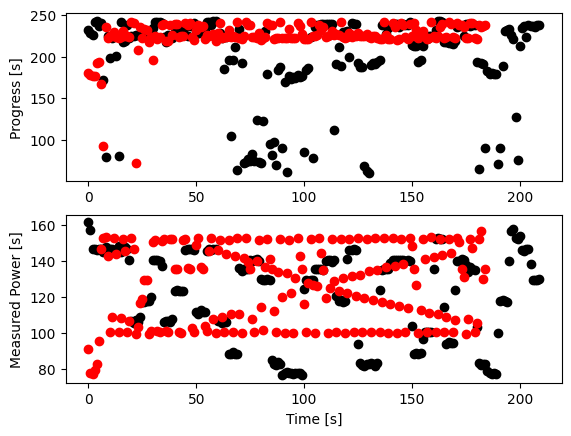

In [27]:
#### Uncomment this to see the time log plots of prgress and power
# def compute_energy_consump(test_data_frame):
#     total_energy = 0
#     for i,t in enumerate(test_data_frame['average_power']['elapsed_time'].iloc[:-1]):
#         total_energy += test_data_frame['average_power']['average_power'].iloc[i] * (test_data_frame['average_power']['elapsed_time'].iloc[i+1]-test_data_frame['average_power']['elapsed_time'].iloc[i])
#     return total_energy

# fig_phase,axs_phase = plt.subplots(2,1)
# experiments = {'data_generation':'k', 'Control':'r'}
# for dirs in experiments.keys():
#     DATA_DIR = get_data_dir(dirs)
#     root,folders,files = next(os.walk(DATA_DIR))
#     test_results = {}
#     for APP in folders:
#         APP_DIR = os.path.join(DATA_DIR, APP)
#         test_results[APP] = {}
#         print(next(os.walk(APP_DIR)))
#         for tar_file in next(os.walk(APP_DIR))[2]:
#             test_results[APP][tar_file] = {}
#             if tar_file.endswith('.tar'):
#                 tar_path = os.path.join(APP_DIR,tar_file)
#                 extract_dir = os.path.join(APP_DIR,tar_file[:-4])  
#                 print("------",tar_path)
#                 if not os.path.exists(extract_dir):
#                     os.makedirs(extract_dir)
                
#                 with tarfile.open(tar_path, 'r') as tar:
#                     tar.extractall(path=extract_dir)
            
#             pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
#             pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
#             pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
#             pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
#             test_results[APP][tar_file]['energy'] = pubEnergy
#             test_results[APP][tar_file]['power'] = compute_power(pubEnergy)
#             test_results[APP][tar_file]['progress'] = measure_progress(pubProgress,test_results[APP][tar_file]['power'])
#             test_results[APP][tar_file]['papi'] = collect_papi(pubPAPI)
#             test_results[APP][tar_file]['PCAP'] = generate_PCAP(pubPCAP)
#             test_results[APP][tar_file]['derived_papi'] = derived_papi(test_results[APP][tar_file]['papi'])   

#     # print(test_results[APP][tar_file])
#     computed_energy = compute_energy_consump(test_results[APP][tar_file]['power'])
#     print("Total Energy consumed: ", computed_energy)
#     print("Total Execution Time: ", test_results[APP][tar_file]['energy'].time.iloc[-1]-test_results[APP][tar_file]['energy'].time.iloc[0])
#     axs_phase[0].scatter(test_results[APP][tar_file]['progress']['progress_frequency_median']['elapsed_time'],test_results[APP][tar_file]['progress']['progress_frequency_median']['median'],color=experiments[dirs])
#     axs_phase[1].scatter(test_results[APP][tar_file]['power']['average_power']['elapsed_time'],test_results[APP][tar_file]['power']['average_power']['average_power'],color=experiments[dirs])
#     axs_phase[1].set_xlabel("Time [s]")
#     axs_phase[0].set_ylabel("Progress [s]")
#     axs_phase[1].set_ylabel("Measured Power [s]")
# plt.savefig('phases.pdf', format='pdf', bbox_inches='tight') 


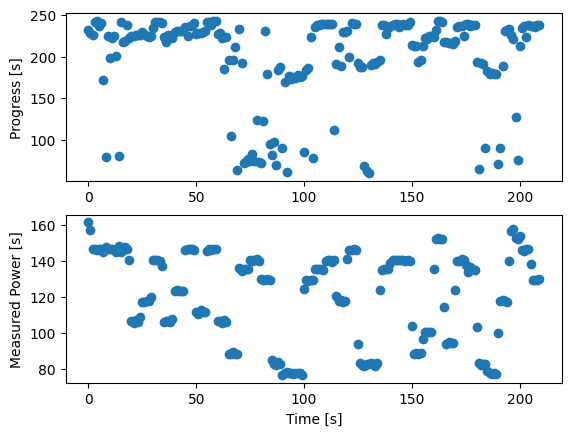

In [12]:
#### Uncomment this to see the time log plots of prgress and power



In [10]:
DATA_DIR = get_data_dir('identification')
root,folders,files = next(os.walk(DATA_DIR))
test_results = {}
for APP in folders:
    APP_DIR = os.path.join(DATA_DIR, APP)
    test_results[APP] = {}
    for file in next(os.walk(APP_DIR))[1]:
        tar_dir = os.path.join(APP_DIR, file)
        test_results[APP][file] = {}
        for tar_file in next(os.walk(tar_dir))[2]:
            test_results[APP][file][tar_file] = {}
            if tar_file.endswith('.tar'):
                tar_path = os.path.join(tar_dir, tar_file)
                extract_dir = os.path.join(tar_dir, tar_file[:-4])  
                
                if not os.path.exists(extract_dir):
                    os.makedirs(extract_dir)
                
                with tarfile.open(tar_path, 'r') as tar:
                    tar.extractall(path=extract_dir)
            
            pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
            pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
            pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
            pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
            test_results[APP][file][tar_file]['energy'] = pubEnergy
            test_results[APP][file][tar_file]['power'] = compute_power(pubEnergy)
            test_results[APP][file][tar_file]['progress'] = measure_progress(pubProgress,test_results[APP][file][tar_file]['power'])
            test_results[APP][file][tar_file]['papi'] = collect_papi(pubPAPI)
            test_results[APP][file][tar_file]['PCAP'] = generate_PCAP(pubPCAP)
            test_results[APP][file][tar_file]['derived_papi'] = derived_papi(test_results[APP][file][tar_file]['papi'])   

print(test_results[APP][file][tar_file])

/home/cc/summer2024/main_codes
/home/cc/summer2024/main_codes/experiment_data/data_generation ['phases-stream-full'] []
/home/cc/summer2024/main_codes/experiment_data/data_generation/phases-stream-full
compressed_iteration_20250122_060419.tar


StopIteration: 

/Users/akhileshraj/Desktop/summer2024/main_codes


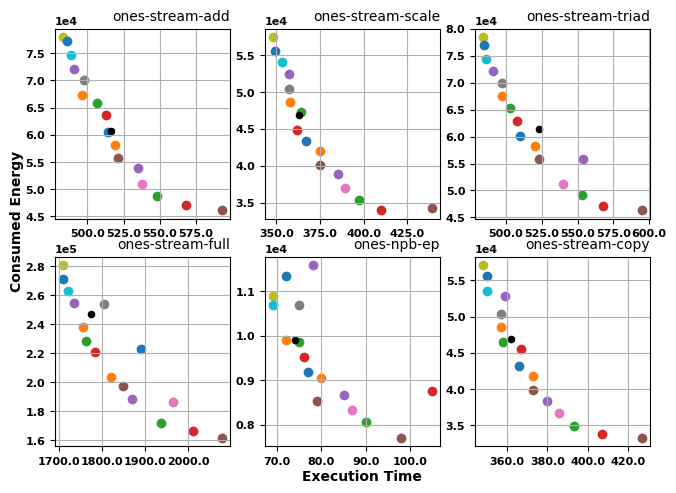

In [105]:
# print(test_results)

fig, axs = plt.subplots(2, 3)
plt.rcParams.update({'font.size': 8, "font.weight": "bold", 'axes.labelsize': 'x-large'})
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2, top=0.9, bottom=0.03, left=0.02, right=0.95)  # Adjust the spacing between subplots
fig.text(0.5, -0.04, 'Execution Time', ha='center', fontsize=10)
fig.text(-0.05, 0.5, 'Consumed Energy', va='center', rotation='vertical', fontsize=10)
index = 0
for app in test_results.keys():
    for trace in test_results[app].keys():
        for tar_file in test_results[app][trace]:
            # print(f"App: {app}")
            # print("Total execution time is: ", test_results[app][trace][tar_file]['power']['average_power']['elapsed_time'].iloc[-1])
            # print("Total energy consumed is: ", test_results[app][trace][tar_file]['power']['average_power']['average_power'].sum())
            axs[index//3, index%3].scatter(test_results[app][trace][tar_file]['power']['average_power']['elapsed_time'].iloc[-1], test_results[app][trace][tar_file]['power']['average_power']['average_power'].sum())
    # Format x-ticks and y-ticks
    axs[index//3, index%3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    axs[index//3, index%3].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    axs[index//3, index%3].set_title(app, fontsize=10, loc='right')
    axs[index//3, index%3].grid(True)

    index += 1

DATA_DIR = get_data_dir('Control')
root,folders,files = next(os.walk(DATA_DIR))
test_results_control = {}
for APP in folders:
    APP_DIR = os.path.join(DATA_DIR, APP)
    test_results_control[APP] = {}
    for file in next(os.walk(APP_DIR))[2]:
        test_results_control[APP][file] = {}
        if file.endswith('.tar'):
            tar_path = os.path.join(APP_DIR, file)
            extract_dir = os.path.join(APP_DIR, file[:-4])  
            
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=extract_dir)
            
        pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
        pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
        pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
        pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        test_results_control[APP][file]['energy'] = pubEnergy
        test_results_control[APP][file]['power'] = compute_power(pubEnergy)
        test_results_control[APP][file]['progress'] = measure_progress(pubProgress,test_results_control[APP][file]['power'])
        test_results_control[APP][file]['papi'] = collect_papi(pubPAPI)
        test_results_control[APP][file]['PCAP'] = generate_PCAP(pubPCAP)
        test_results_control[APP][file]['derived_papi'] = derived_papi(test_results_control[APP][file]['papi'])   


index = 0
for app in test_results_control.keys():
    for trace in test_results_control[app].keys():
        # print(f"App: {app}")
        # print("Total execution time is: ", test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        # print("Total energy consumed is: ", test_results_control[app][trace]['power']['average_power']['average_power'].sum())
        axs[index//3, index%3].scatter(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], test_results_control[app][trace]['power']['average_power']['average_power'].sum(), color='black', s=20)
    # Format x-ticks and y-ticks
    # axs[index//3, index%3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    # axs[index//3, index%3].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # axs[index//3, index%3].set_title(app)
    # axs[index//3, index%3].grid(True)
    index += 1
plt.show()